In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('titanic',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")

Local environment
Added the following directory to the PYTHONPATH: /home/jdowling/Projects/mlfs-book


In [ ]:
from PIL import Image
import datetime
import requests
import xgboost as xgb
import os
import hopsworks
import pandas as pd
import datetime
from mlfs import config
import joblib

In [3]:
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")
project = hopsworks.login()
fs = project.get_feature_store()

2025-01-09 08:39:23,215 INFO: Initializing external client
2025-01-09 08:39:23,217 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-09 08:39:25,829 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398


In [ ]:
mr = project.get_model_registry()
model_reg = mr.get_model("titanic", version=1)
feature_view = model_reg.get_feature_view()

# Downloads the model to a local temp directory (model_dir)
model_dir = model_reg.download()
# Load XGBoost model from local temp directory using joblib
model = joblib.load(model_dir + "/titanic_model.pkl")

In [5]:
feature_view.init_batch_scoring(training_dataset_version=1)

batch_data = feature_view.get_batch_data()
batch_data

/arrow/cpp/src/arrow/status.cc:137: DoAction result was not fully consumed: Cancelled: Flight cancelled call, with message: CANCELLED. Detail: Cancelled


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.40s) 


,age,pclass,fare,parch,sibsp,label_encoder_embarked_,label_encoder_sex_
0,42.000000,2,13.000000,0,0,2,0
1,20.000000,3,8.662500,0,0,2,1
2,29.699118,3,8.662500,0,0,2,1
3,47.000000,2,15.000000,0,0,2,1
4,35.000000,3,7.895800,0,0,0,1
...,...,...,...,...,...,...,...
888,2.000000,2,26.000000,1,1,2,0
889,47.000000,3,9.000000,0,0,2,1
890,24.000000,2,14.500000,2,0,2,0
891,6.750001,1,2.897503,0,0,2,1


In [6]:
y_pred = model.predict(batch_data)
passenger_survived = y_pred[y_pred.size-1]
passenger_survived

0

In [7]:
passenger_details = batch_data.iloc[-1]
def remove_last_line_from_string(s):
    return s[:s.rfind('\n')]
passenger_details = remove_last_line_from_string(str(passenger_details))

with open(f"{root_dir}/docs/_includes/titanic.html", "w", newline="\n") as file:
    file.write(passenger_details)

In [8]:
img_url = "https://raw.githubusercontent.com/featurestorebook/mlfs-book/main/docs/titanic/assets/img/titanic_" + str(passenger_survived) + ".jpg"
img = Image.open(requests.get(img_url, stream=True).raw)            
output_img_path = f"{root_dir}/docs/titanic/assets/img/latest_titanic_survival.jpg"
img.save(output_img_path)

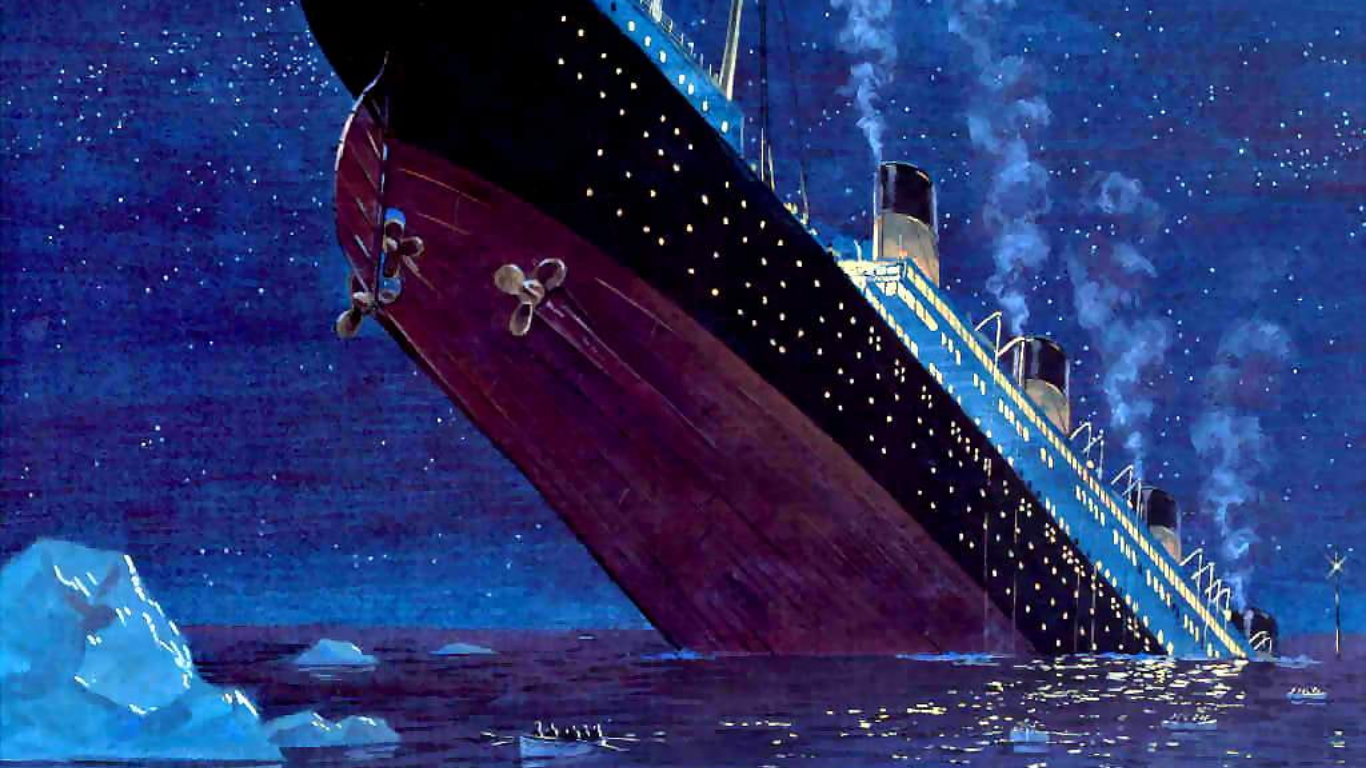

In [9]:
from IPython.display import display
display(img)

In [ ]:
today = datetime.datetime.now() - datetime.timedelta(0)
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/titanic") == False:
    dataset_api.mkdir("Resources/titanic")
dataset_api.upload(output_img_path, f"Resources/titanic/{str_today}", overwrite=True)
proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/titanic")